In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings('ignore')
from scipy import stats
from datetime import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
df = pd.read_csv('/Users/anishamalhotra/Documents/Flatiron/Phase2Project/kc_house_data_train.csv')
pd.set_option('display.max_columns', None)
# df.set_index('id',drop=True)
df = df.drop('Unnamed: 0', axis=1)

# Data Cleaning

In [3]:
df.isna().sum() #no missing values

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Bathrooms with a value less than 0.75 do not include a shower, therefore must be faulty data. Let's impute these rows with the median bathroom value.

In [4]:
df['bathrooms'] = df['bathrooms'].replace(to_replace=[0,.05], value=df['bathrooms'].median())



One bedroom in particular has a value of 33. Looking at other houses with 3 bedrooms, this row seems to match other variable values. Let's assume 33 was a type and change the value to 3.

In [5]:
#based on looking at other houses with 3 bedrooms, other columns fit the description of the 33 bedroom one
#leads me to believe this was a typo
df['bedrooms'] = df['bedrooms'].replace(to_replace=33, value=3)


# Exploratory Data Anaylsis

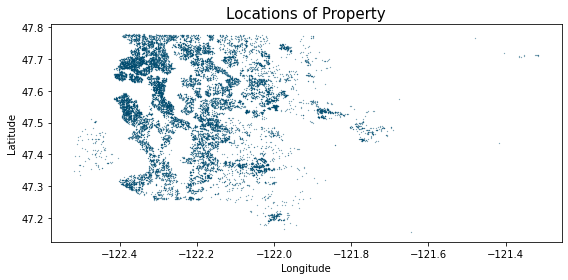

In [6]:
# overall region plot
plt.figure(figsize = (8,4))
ax = plt.subplot(1,1,1)
plt.plot(df['long'], df['lat'], 'o', markersize = 0.2, color = '#004c70')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Locations of Property', fontsize = 15)

plt.tight_layout()

First, let's get a good idea of the location of all of the properties in the dataset.

In [7]:
df['price'].describe()

count    1.729000e+04
mean     5.407395e+05
std      3.733190e+05
min      7.500000e+04
25%      3.210000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

Text(0.5, 0, 'Price')

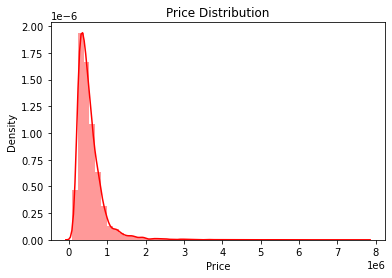

In [8]:
#check the distribution
sns.distplot(df['price'], color = 'red')
# plt.xticks(rotation=90);
plt.title('Price Distribution')
plt.xlabel('Price')

Price is data is skewed right and does not have a normal distribution. 

Text(0, 0.5, 'Price')

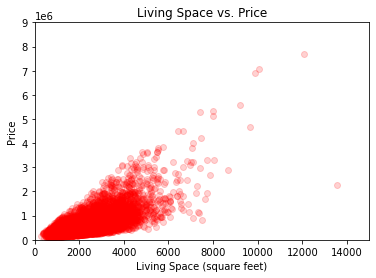

In [9]:
fig, ax = plt.subplots()
ax.scatter(df['sqft_living'],df['price'],c ='red',alpha = 0.18)
ax.set_xlim(0,15000)
ax.set_ylim(0,9000000)
ax.set_title('Living Space vs. Price')
ax.set_xlabel('Living Space (square feet)')
ax.set_ylabel('Price')

There seems to a be a positive correlation between living space and price. However, there are some outliers so let's cap sqft_living at 5000.

In [10]:
df.loc[df["sqft_living"]>8000, "sqft_living"] = 8000


In [11]:
df[df['sqft_living']==8000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1979,8907500070,20150413T000000,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
2232,2470100110,20140804T000000,5570000.0,5,5.75,8000,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
3275,1225069038,20140505T000000,2280000.0,7,8.00,8000,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800
4217,2303900035,20140611T000000,2888000.0,5,6.25,8000,64033,2.0,0,4,3,13,6120,2550,1965,2003,98177,47.7295,-122.372,4140,81021
6903,9808700762,20140611T000000,7062500.0,5,4.50,8000,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
7183,6072800246,20140702T000000,3300000.0,5,6.25,8000,21738,2.0,0,0,3,11,8020,0,2001,0,98006,47.5675,-122.189,4160,18969
7519,9208900037,20140919T000000,6885000.0,6,7.75,8000,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
10366,6762700020,20141013T000000,7700000.0,6,8.00,8000,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
14668,1247600105,20141020T000000,5110800.0,5,5.25,8000,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
15816,1924059029,20140617T000000,4668000.0,5,6.75,8000,13068,1.0,1,4,3,12,4820,4820,1983,2009,98040,47.5570,-122.210,3270,10454


Text(0, 0.5, 'Price')

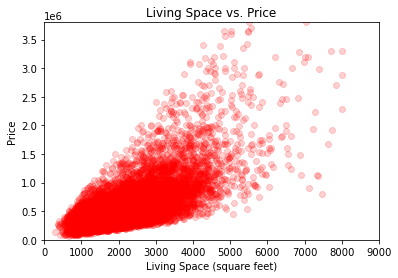

In [12]:

fig, ax = plt.subplots()
ax.scatter(df['sqft_living'],df['price'],c ='red',alpha = 0.18)
ax.set_xlim(0,9000)
ax.set_ylim(0,3800000)
ax.set_title('Living Space vs. Price')
ax.set_xlabel('Living Space (square feet)')
ax.set_ylabel('Price')

Mathematically, an outlier is considered greater than about 4500 based on our data, however too much of our data falls above 4500 square feet, so I used my own analysis to drop outliers.

Text(0, 0.5, 'Price')

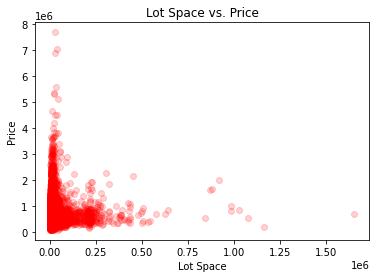

In [13]:
fig, ax = plt.subplots()
ax.scatter(df['sqft_lot'],df['price'],c ='red',alpha = 0.18)

ax.set_title('Lot Space vs. Price')
ax.set_xlabel('Lot Space')
ax.set_ylabel('Price')

It looks like lot space is not as import as living space to the consumer because price has a stronger positive correlation with living space.

Text(0, 0.5, 'Price')

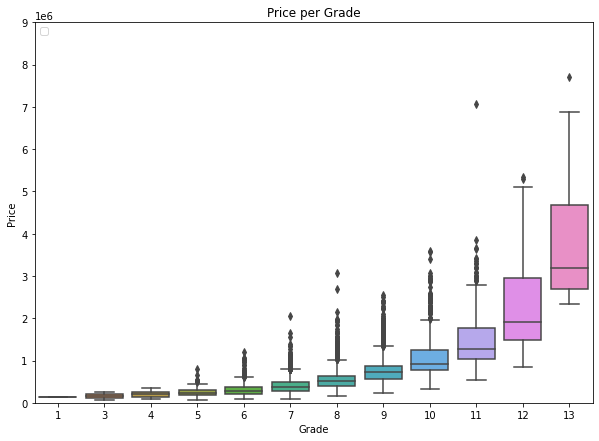

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))
fig = sns.boxplot(x='grade', y="price",hue='grade', data=df ,dodge=False)
fig.legend('',loc =2)
fig.axis(ymin=0, ymax=9000000);
plt.title('Price per Grade')
plt.xlabel('Grade')
plt.ylabel('Price')

It appears that as the grade of a house goes up, the median price increases as well.

Text(0.5, 1.0, 'Correlation Heat Map')

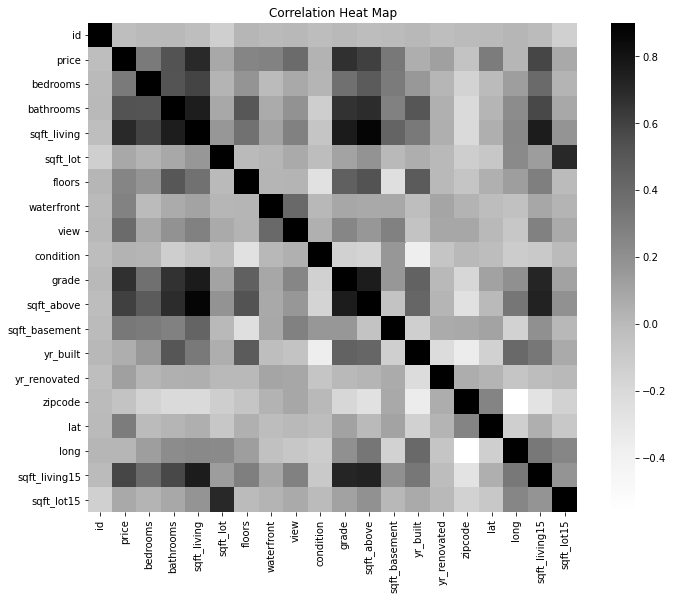

In [15]:
corrmat = df.corr()
fig, ax = plt.subplots(figsize=(12, 9))
heatm = sns.heatmap(corrmat, vmax=0.9, square=True, cmap = 'Greys');
ax.set_title('Correlation Heat Map')


I created a heatmap to visualize the correlations between variables better. Now let's take the highest correlations and map those.

Text(0.5, 1.0, 'Heat Map with Largest Correlation to Price')

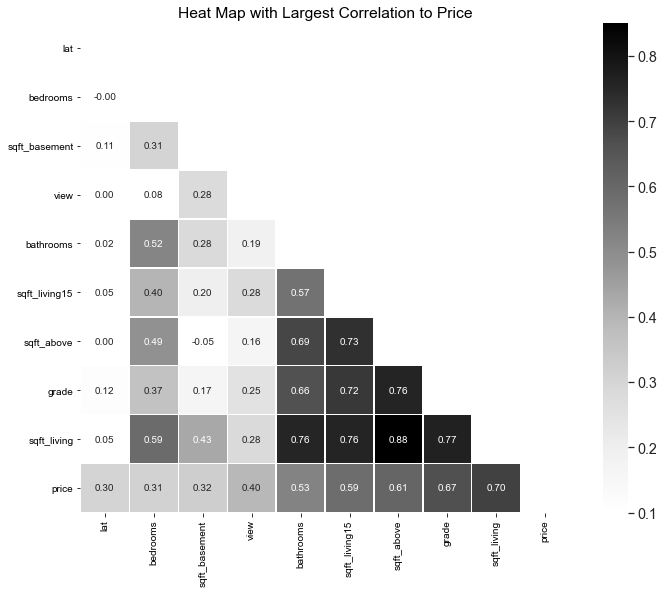

In [16]:
#saleprice correlation matrix
n = 10 #number of parameters for heatmap
cols = corrmat.nlargest(n, 'price')['price'].index
cols2 = np.array(list(reversed(cols)))
cm = df[cols2].corr()
# mask to get only the upper triangle of the matrix, as the lower one is just repeated information
mask = np.triu(np.ones_like(cm, dtype=np.bool))
# adjust mask and df

cm2 = cm.iloc[1:,:-1].copy()
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.3)
heatmap = sns.heatmap(cm,mask=mask, cbar=True, annot=True, square=True, cmap = 'Greys', fmt='.2f', vmin=.1, vmax=.85,linewidth=0.3, annot_kws={'size': 10}, yticklabels=cols2, xticklabels=cols2)
ax.set_title('Heat Map with Largest Correlation to Price')



Top correlations heat map. The sqft_above and sqft_living correlation is very high, due to multicollinearity and overlapping daya so we do not need both of those variables for our model. Therefore, we will only use sqft_living for the model.

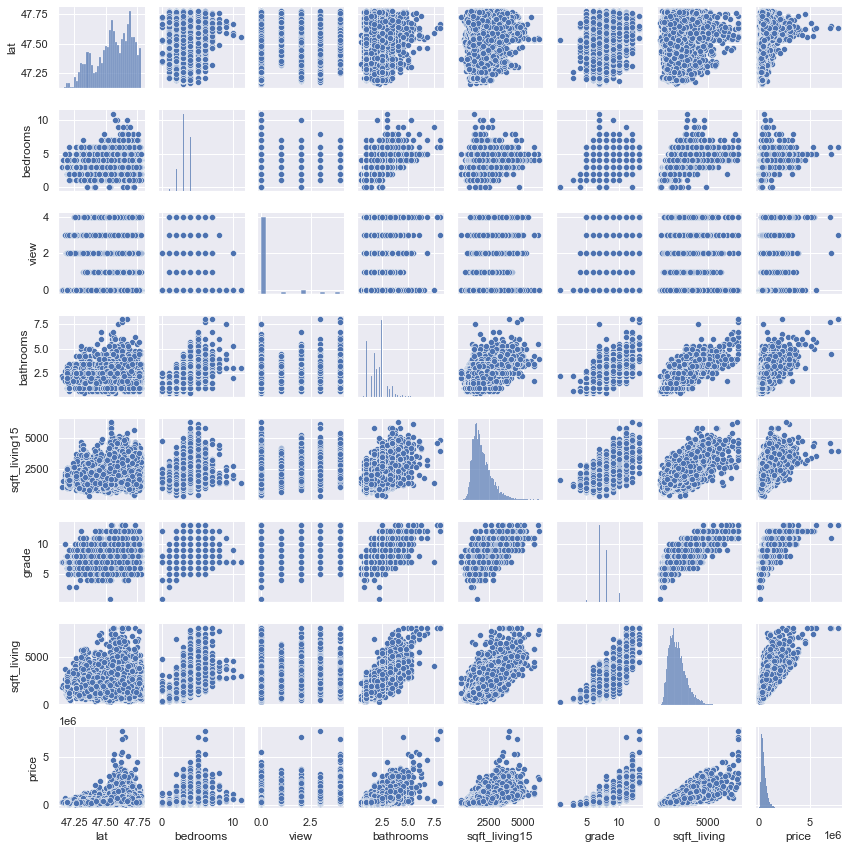

In [40]:
sns.set()
cols = ['lat', 'bedrooms', 'view', 'bathrooms', 'sqft_living15', 'grade', 'sqft_living','price']
pairp = sns.pairplot(df[cols], size = 1.5)
plt.show()

Pair plot showing correlations between variables. Didn't include variables that overlap data due to multicollinearity.

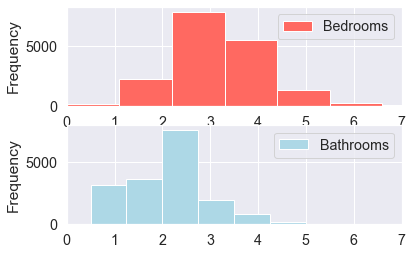

In [17]:
fig, ax = plt.subplots(2)
ax[0].hist(df['bedrooms'],color='#ff6961',label='Bedrooms')
ax[0].set_xlim(0,7)
# ax[0].set_xlabel('Number of Bedrooms')
ax[0].set_ylabel('Frequency')
# ax[0].set_title('Bedrooms')
ax[1].hist(df['bathrooms'],color='#ADD8E6',label='Bathrooms')
ax[1].set_xlim(0,7)
# ax[1].set_xlabel('Number of Bathrooms')
ax[1].set_ylabel('Frequency')
# ax[1].set_title('Bathrooms')
ax[0].legend()
ax[1].legend()
#side by side

Three bedrooms and 2.5 bathrooms have the highest frequency in King County.

In [18]:
#coverting date to datetime object
def convert_dt(obj):
    obj = obj[0:8]
    date_time_obj=datetime.strptime(obj, '%Y%m%d' )
    return date_time_obj

In [19]:
df['date'] = df['date'].map(convert_dt)

Text(0, 0.5, 'Frequency')

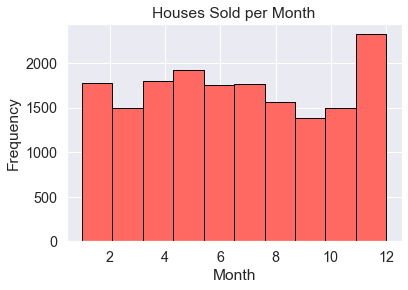

In [20]:
month_sold = df['date'].dt.month
fig, ax = plt.subplots()
ax.hist(month_sold, color='#ff6961',edgecolor='black')
ax.set_title('Houses Sold per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Frequency')

No obvious trend where more houses are sold. It appears that most houses were sold in December but we would need multiple years of data to make a clear conclusion based on date.

Text(0, 0.5, 'Price')

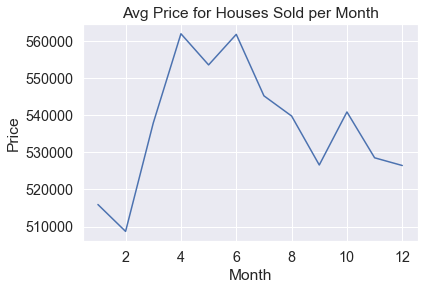

In [21]:
month_price = df.groupby(df['date'].dt.month).agg('mean')['price']
fig, ax = plt.subplots()
ax.plot(month_price.index,month_price.values)
ax.set_title('Avg Price for Houses Sold per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Price')

Prices for houses seems to be at its highest around April, but again we would need more data in order to make a conlusion based on time period.

Text(0, 0.5, 'Frequency')

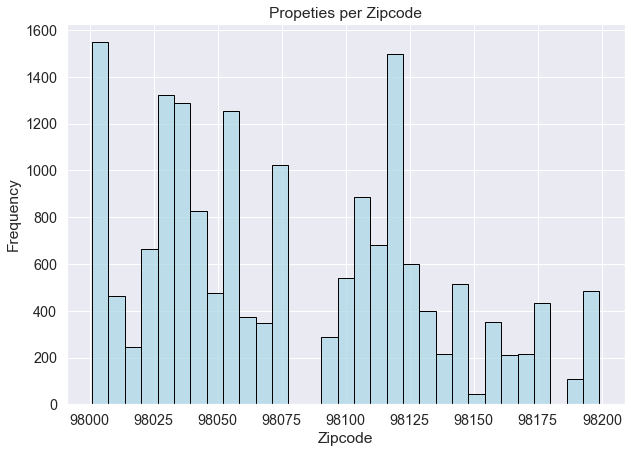

In [22]:
# zip_price = df.groupby('zipcode').agg('mean')['price']

fig, ax = plt.subplots(figsize = (10,7))
sns.histplot(df['zipcode'],color='#ADD8E6',edgecolor='black')
ax.set_title('Propeties per Zipcode')
ax.set_xlabel('Zipcode')
ax.set_ylabel('Frequency')

# Feature Engineering

In [23]:
df['years_old'] = 2021 - df['yr_built']

In [24]:
df['sqft_yard'] = df['sqft_lot'] - (df['sqft_living']/df['floors'])

### Population

In [25]:
# imported new csv file to get population of each zip code
zips = pd.read_csv('/Users/anishamalhotra/Documents/Flatiron/Phase2Project/zip_code_database.csv')
#dropped all irrelevent columns
zips = zips.drop(['type','decommissioned','acceptable_cities','primary_city','unacceptable_cities','state','county','timezone','area_codes','world_region','country','latitude','longitude'], axis=1)
zips = zips.rename(columns={'zip':'zipcode'})
#merged population column into df
df = df.merge(zips, how='left',on='zipcode')
df = df.rename(columns={'irs_estimated_population_2015':'population'})

In [26]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,years_old,sqft_yard,population
0,2591820310,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,35,7858.0,40510
1,7974200820,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,44,3830.0,46850
2,7701450110,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,24,9008.0,39630
3,9522300010,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,31,12328.0,46730
4,9510861140,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,17,4101.0,65300


Text(0, 0.5, 'Price')

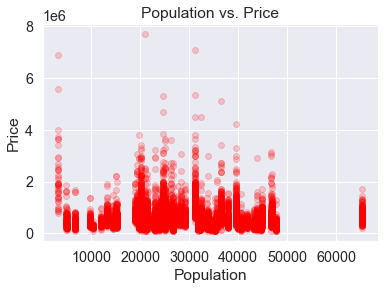

In [27]:
fig, ax = plt.subplots()
ax.scatter(df['population'],df['price'],c ='red',alpha = 0.18)

ax.set_title('Population vs. Price')
ax.set_xlabel('Population')
ax.set_ylabel('Price')

Population does not seem to have an effect on Price, so we should not include this in the model.

### Crimes by Zipcode

In [28]:
# imported new csv file to get population of each zip code
crime = pd.read_csv('/Users/anishamalhotra/Documents/Flatiron/Phase2Project/crimes.csv')
#dropped all irrelevent columns
crime = crime.drop(['case_number','incident_datetime','FCR','address_1','city','state','created_at','updated_at','hour_of_day','day_of_week','Incident Block Location'], axis=1)
crime = crime.rename(columns={'zip':'zipcode'})

In [29]:
#selected columns from each df before merge
crime_count_per_zip = crime.groupby('zipcode').count()
avg_price_per_zip = pd.DataFrame(df.groupby('zipcode').agg('mean')['price'])

In [30]:
#zipcode was default index so reset index and dropped row with string in it
avg_price_per_zip = avg_price_per_zip.reset_index()
crime_count_per_zip = crime_count_per_zip.reset_index()
crime_count_per_zip = crime_count_per_zip.drop(207, axis=0)


In [31]:
#changed object type to int type for merge and then merged
crime_count_per_zip['zipcode'] = crime_count_per_zip['zipcode'].astype(int)
crime_price_df = avg_price_per_zip.merge(crime_count_per_zip, how='left',on='zipcode')

Text(0.5, 1.0, 'Incident Count vs. Price by Zipcode')

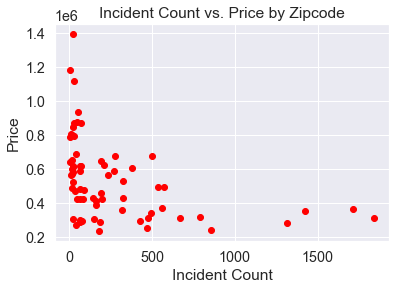

In [32]:
fig, ax = plt.subplots()
ax.scatter(crime_price_df['incident_type'],crime_price_df['price'],c ='red')
ax.set_xlabel('Incident Count')
ax.set_ylabel('Price')
ax.set_title('Incident Count vs. Price by Zipcode')

After plotting incident count vs. price, we can see that as incident rate increases, price decreases. Now, we have to incorporate this data into our original dataframe so we can include it in our model. 

In [33]:
crime_price_df['incident_type']

0     1313.0
1      180.0
2      429.0
3       22.0
4       12.0
       ...  
65      13.0
66    1841.0
67     183.0
68     146.0
69       2.0
Name: incident_type, Length: 70, dtype: float64

In [34]:
def crime_level(number):
    if number<=250: 
        return ('low')
    elif number>600:
        return('high')
    elif number==np.nan:
        return('low')
    else:
        return ('medium') #between 250 and 600
crime_price_df['crime_rate'] = crime_price_df['incident_type'].map(crime_level)

In [35]:
crime_price_df['crime_rate'].value_counts()

low       48
medium    15
high       7
Name: crime_rate, dtype: int64

In [36]:
#drop columns not wanted in merge
crime_to_merge = crime_price_df.drop(['price'], axis=1)

In [37]:
#merge with original df
df = df.merge(crime_to_merge, how='left',on='zipcode')
df = df.rename(columns={'incident_type':'crime_count'})

Text(0.5, 1.0, 'Crime Level vs. AVG Price')

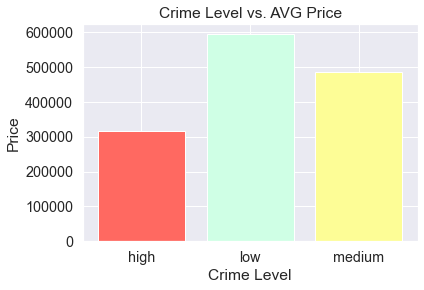

In [38]:
x = df.groupby('crime_rate').agg('mean')['price'].index
y = df.groupby('crime_rate').agg('mean')['price'].values

fig, ax = plt.subplots()
ax.bar(x,y,color=['#ff6961','#cfffe5','#fdfd96'])
ax.set_xlabel('Crime Level')
ax.set_ylabel('Price')
ax.set_title('Crime Level vs. AVG Price')

# Statistical Tests

In [39]:
H0_crime = 'Low crime area houses, medium crime area houses, and high crime area houses cost the same.'
H1_crime = 'The null hypothesis is not true.'
alpha = .05
#ANOVA
low_crime_prices = df[df['crime_rate']=='low']['price']
medium_crime_prices = df[df['crime_rate']=='medium']['price']
high_crime_prices = df[df['crime_rate']=='high']['price']
crime_pval = stats.f_oneway(low_crime_prices, medium_crime_prices, high_crime_prices).pvalue
crime_conclusion = 'Because the p-value is less than the alpha, we reject the null hypothesis.'


In [40]:
H0_wf = 'Houses with a waterfront cost the same as houses without.'
H1_wf = 'Houses with a waterfront cost more than houses without.'
alpha = .05
#2 sample t-test
wf = df[df['waterfront']==1]['price']
no_wf = df[df['waterfront']==0]['price']
wf_pval = stats.ttest_ind(wf,no_wf).pvalue

wf_conclusion = 'Because the p-value is less than the alpha, we reject the null hypothesis.'

In [41]:
H0_cond = 'Houses with a condition rating of 4 or 5 cost the same as houses with a condition rating of 1,2, or 3.'
H1_cond = 'Houses with a condition rating of 4 or 5 cost more than houses with a condition rating of 1,2, or 3.'
alpha = .05
#2 sample t-test
good_cond = df[df['condition']>3]['price']
poor_cond = df[df['condition']<4]['price']
cond_pval = stats.ttest_ind(good_cond,poor_cond).pvalue

cond_conclusion = 'Because the p-value is greater than the alpha, we fail to reject the null hypothesis.'
#shows us condition does not have a significant effect on price

In [42]:
H0_old = 'Houses that are older than 30 years cost the same as houses 30 years old and younger.'
H1_old = 'Houses that are older than 30 years cost less than houses 30 years old and younger.'
alpha = .05
#2 sample t-test
new = df[df['years_old']>30]['price']
old = df[df['years_old']<=30]['price']
old_pval = stats.ttest_ind(new,old).pvalue
old_conclusion = 'Because the p-value is less than the alpha, we reject the null hypothesis.'


In [43]:
df['view'].value_counts()

0    15571
2      775
3      410
4      270
1      264
Name: view, dtype: int64

In [44]:
H0_wf = 'Houses with a waterfront cost the same as houses without.'
H1_wf = 'Houses with a waterfront cost more than houses without.'
alpha = .05
#2 sample t-test
wf = df[df['waterfront']==1]['price']
no_wf = df[df['waterfront']==0]['price']
wf_pval = stats.ttest_ind(wf,no_wf).pvalue

wf_conclusion = 'Because the p-value is less than the alpha, we reject the null hypothesis.'

# Model

### Simple Regressions

R-squared: 0.48523130207103904


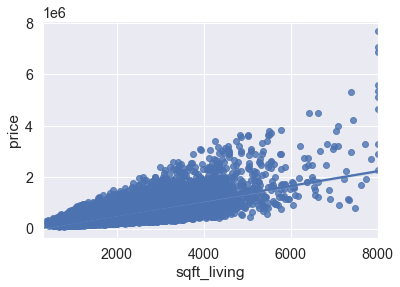

In [45]:
model = ols(formula = "price~sqft_living", data=df).fit()
print(f"R-squared: {model.rsquared}")

sns.regplot(x='sqft_living', y='price', data=df);

R-squared: 0.4438423664493838


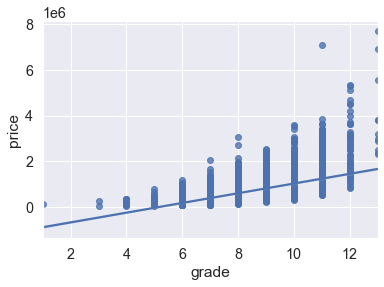

In [46]:
model = ols(formula = "price~grade", data=df).fit()
print(f"R-squared: {model.rsquared}")

sns.regplot(x='grade', y='price', data=df); 

R-squared: 0.36937184435917203


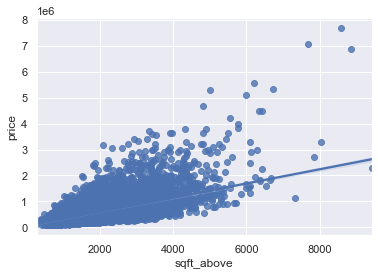

In [71]:
model = ols(formula = "price~sqft_above", data=df).fit()
print(f"R-squared: {model.rsquared}")

sns.regplot(x='sqft_above', y='price', data=df);

R-squared: 0.3428887937324675


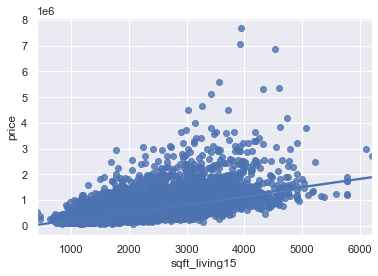

In [72]:
model = ols(formula = "price~sqft_living15", data=df).fit()
print(f"R-squared: {model.rsquared}")

sns.regplot(x='sqft_living15', y='price', data=df);

R-squared: 0.2757565323441117


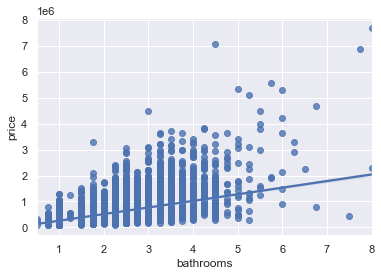

In [73]:
model = ols(formula = "price~bathrooms", data=df).fit()
print(f"R-squared: {model.rsquared}")

sns.regplot(x='bathrooms', y='price', data=df);

R-squared: 0.09845454540161236


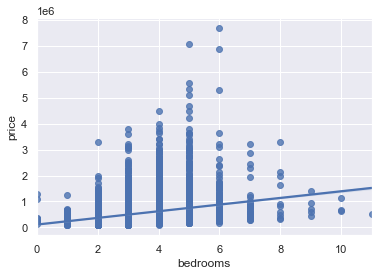

In [74]:
model = ols(formula = "price~bedrooms", data=df).fit()
print(f"R-squared: {model.rsquared}")

sns.regplot(x='bedrooms', y='price', data=df);

R-squared: 0.27072285446490707


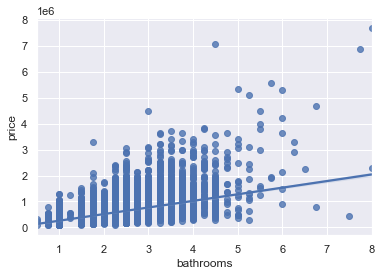

In [75]:
model = ols(formula = "bathrooms~bedrooms", data=df).fit()
print(f"R-squared: {model.rsquared}")

sns.regplot(x='bathrooms', y='price', data=df);

In [76]:

# model_df = pd.get_dummies(df,columns=['zipcode','crime_rate'],drop_first=True)
# formula='price~bedrooms+bathrooms+sqft_living+waterfront+view+condition+grade+lat+long+sqft_living15+years_old+population+zipcode_98002+zipcode_98003+zipcode_98004+zipcode_98005+zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010+zipcode_98011+zipcode_98014+zipcode_98019+zipcode_98022+zipcode_98023+zipcode_98024+zipcode_98027+zipcode_98028+zipcode_98029+zipcode_98030+zipcode_98031+zipcode_98032+zipcode_98033+zipcode_98034+zipcode_98038+zipcode_98039+zipcode_98040+zipcode_98042+zipcode_98045+zipcode_98052+zipcode_98053+zipcode_98055+zipcode_98056+zipcode_98058+zipcode_98059+zipcode_98065+zipcode_98070+zipcode_98072+zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092+zipcode_98102+zipcode_98103+zipcode_98105+zipcode_98106+zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112+zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118+zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126+zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146+zipcode_98148+zipcode_98155+zipcode_98166+zipcode_98168+zipcode_98177+zipcode_98178+zipcode_98188+zipcode_98198+zipcode_98199'

# model = ols(formula=formula,data=model_df).fit()
# model.summary()


In [47]:
model_df = df[['price','bedrooms','bathrooms','sqft_living','waterfront','grade','zipcode','years_old','crime_rate']]


In [48]:
dummy_df = pd.get_dummies(model_df, columns=['zipcode','waterfront','crime_rate'])

In [49]:
# dummy_df.corr()

In [50]:
x = dummy_df.drop(columns='price')
y = dummy_df.price

lr = LinearRegression()
hp = lr.fit(x,y)

print(hp.coef_)
print(hp.intercept_)
print(hp.score(x,y))

[-3.35491659e+04  2.76204435e+04  1.93490867e+02  7.44904280e+04
  1.60777850e+03  1.09392984e+14 -1.08749758e+12 -3.39515492e+13
 -1.08749683e+12 -1.08749734e+12 -1.08749735e+12 -1.08749739e+12
 -1.08749736e+12 -1.08749754e+12 -1.08749751e+12 -1.08749750e+12
 -1.08749754e+12 -3.39515492e+13 -1.08749766e+12 -3.39515490e+13
 -3.39515490e+13 -1.08749751e+12 -1.08749743e+12 -1.08749762e+12
 -1.08749761e+12 -3.39515492e+13 -1.08749726e+12 -1.08749742e+12
 -3.39515492e+13 -3.39515479e+13 -1.08749711e+12  1.09392984e+14
 -3.39515491e+13 -1.08749741e+12 -3.39515490e+13 -1.08749758e+12
 -1.08749752e+12  1.09392984e+14 -3.39515491e+13 -3.39515491e+13
 -3.39515492e+13 -1.08749748e+12 -1.08749746e+12 -1.08749745e+12
 -3.39515491e+13 -3.39515492e+13 -1.08749716e+12 -1.08749732e+12
 -1.08749719e+12  1.09392984e+14 -1.08749731e+12 -3.39515491e+13
 -1.08749718e+12 -1.08749705e+12 -1.08749733e+12 -1.08749735e+12
 -1.08749734e+12 -1.08749747e+12 -1.08749717e+12 -1.08749734e+12
 -1.08749744e+12 -1.08749

In [51]:
y_pred = lr.predict(x)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
rmse

173273.58588729653

Text(0, 0.5, 'Predictions')

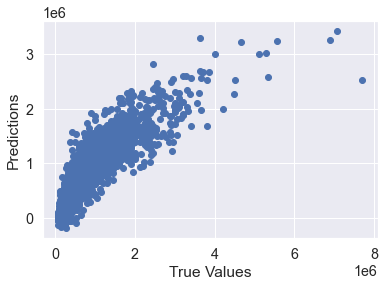

In [52]:
## The line / model
plt.scatter( df['price'], y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

### Plotting the Residuals

<AxesSubplot:ylabel='price'>

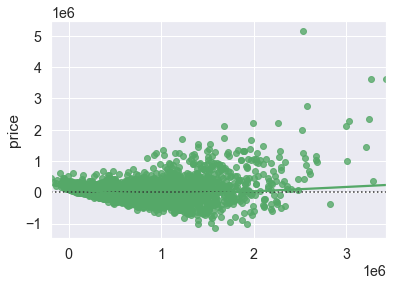

In [53]:
sns.residplot(y_pred, df['price'], lowess=True, color="g")

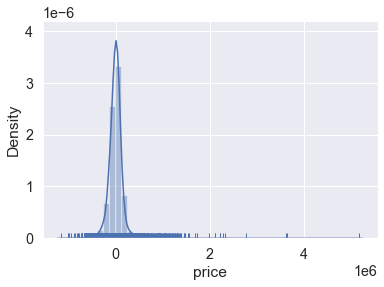

In [54]:
residuals =  df['price']- y_pred
sns.distplot(residuals, kde=True, rug=True);

In [55]:
stats.shapiro(residuals)

ShapiroResult(statistic=0.7372218370437622, pvalue=0.0)

Because the p-value is less than 0.05, we reject the null hypothesis that our residuals are a normal distribution

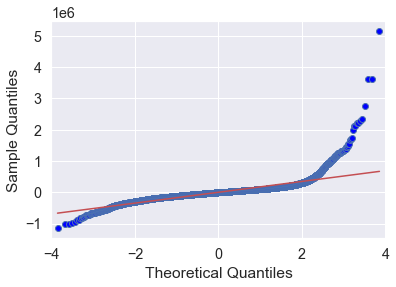

In [56]:
fig = sm.qqplot(residuals,line='s')
plt.show()

Let's try taking the log of our target variable.

array([[<AxesSubplot:title={'center':'log_price'}>]], dtype=object)

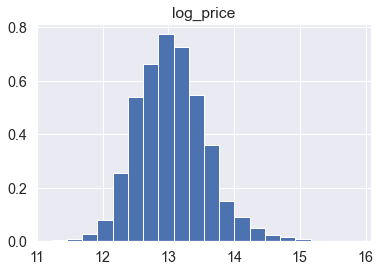

In [57]:
df['log_price'] = np.log(df['price'])
df.hist(column=['log_price'], bins=20, density =True)

In [58]:
subset=['bedrooms','bathrooms','sqft_living','waterfront','grade','zipcode','years_old','crime_rate']
#instantiate a linear regression object
lm_log = LinearRegression()

#fit the linear regression to the data
lm_log.fit(dummy_df, df['log_price'])
y_log_pred = lm_log.predict(dummy_df)



<AxesSubplot:ylabel='log_price'>

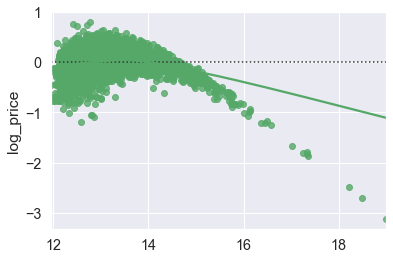

In [59]:
sns.residplot(y_log_pred, df['log_price'], lowess=True, color="g")

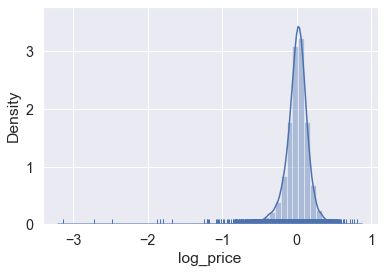

In [60]:
log_residuals =  df['log_price']- y_log_pred
sns.distplot(log_residuals, kde=True, rug=True);

In [61]:
stats.shapiro(log_residuals)

ShapiroResult(statistic=0.8917695879936218, pvalue=0.0)

Still not a normal distribution based on our p-value.

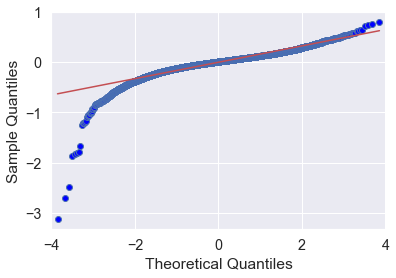

In [62]:
fig = sm.qqplot(log_residuals,line='s')
plt.show()

# Model Evaluation

#### Original Model

In [63]:
features = ['bedrooms','bathrooms','sqft_living','waterfront','grade','zipcode','years_old','crime_rate']
features_df = pd.get_dummies(df[features], columns=['zipcode','waterfront','crime_rate','grade'])
target = df['price']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target, random_state=9,test_size=0.2)


In [65]:
#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 160283.4922700537


In [66]:
#use fitted model to predict on the test examples
y_test_pred = lm.predict(X_test)

#evaluate the predictions on the test examples
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 154236.01139483918
Training:  160283 vs. Testing:  154236


<AxesSubplot:xlabel='price'>

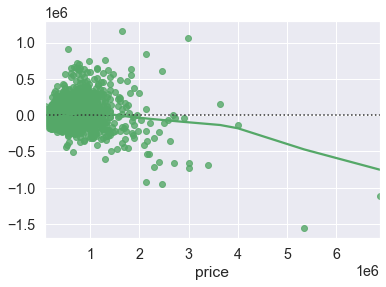

In [67]:
sns.residplot( y_test, y_test_pred,lowess=True, color="g")

#### Log Model

In [111]:
y_log = np.log(y_train)

In [69]:
#instantiate a linear regression object
lm_log = LinearRegression()

#fit the linear regression to the data
lm_log = lm_log.fit(X_train, y_log)

log_train_pred = lm_log.predict(X_train)

In [70]:
#log_train_pred the predictions to get them on the same original scale 
y_train_pred = np.exp(log_train_pred)

In [71]:
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, log_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 658443.147651841


In [103]:
log_test_pred = lm_log.predict(X_test)
#exponentiate the predictions to get them on the same original scale 
log_test_pred = np.exp(log_test_pred)
log_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, log_test_pred))


print('Testing Root Mean Squared Error:' , log_test_rmse)

Testing Root Mean Squared Error: 136243.7076432464


In [72]:
y_test_pred = lm_log.predict(X_test)


#our model predcicte the log of gross, so now we must exponentiate to get the value in $
y_test_pred = np.exp(y_test_pred)

log_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing Root Mean Squared Error:' , log_test_rmse)


print('Training: ', int(train_rmse), "vs. Testing: ", int(log_test_rmse))

Testing Root Mean Squared Error: 136243.7076432464
Training:  658443 vs. Testing:  136243


## Polynomial Features

In [146]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(features_df)
poly2_columns = poly_2.get_feature_names(features_df.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()

bedrooms  bathrooms  sqft_living  years_old  zipcode_98001  zipcode_98002  \
0       4.0       2.25       2070.0       35.0            0.0            0.0   
1       5.0       3.00       2900.0       44.0            0.0            0.0   
2       4.0       2.50       3770.0       24.0            0.0            0.0   
3       3.0       3.50       4560.0       31.0            0.0            0.0   
4       3.0       2.50       2550.0       17.0            0.0            0.0   

   zipcode_98003  zipcode_98004  zipcode_98005  zipcode_98006  zipcode_98007  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            1.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   zipcode_98008  zipcode_98010  zipcode_98011  zipcode_98014  zipcode_98019  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   zipcode_98022  zipcode_98023  zipcode_98024  zipcode_98027  zipcode_98028  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   zipcode_98029  zipcode_98030  zipcode_98031  zipcode_98032  zipcode_98033  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   zipcode_98034  zipcode_98038  zipcode_98039  zipcode_98040  zipcode_98042  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            1.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   zipcode_98045  zipcode_98052  zipcode_98053  zipcode_98055  zipcode_98056  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            1.0            0.0            0.0            0.0   

   zipcode_98058  zipcode_98059  zipcode_98065  zipcode_98070  zipcode_98072  \
0            1.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   zipcode_98074  zipcode_98075  zipcode_98077  zipcode_98092  zipcode_98102  \
0            0.0            0.0            0.0            0.0            0.

In [120]:
len(poly2_columns)

4655

In [147]:
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(df_poly2, target, random_state=9,test_size=0.2)


In [148]:
# instantiate a linear regression object
lm_2 = LinearRegression()

#fit the linear regression to the data
lm_2 = lm_2.fit(X_train_poly, y_train_poly)

y_train_pred_poly = lm_2.predict(X_train_poly)

train_rmse_poly = np.sqrt(metrics.mean_squared_error(y_train_poly, y_train_pred_poly))


print('Training Root Mean Squared Error:' , train_rmse_poly)

Training Root Mean Squared Error: 120269.31982957675


In [133]:
# use fitted model to predict on test data
y_pred_poly = lm_2.predict(X_test_poly)

test_2rmse = np.sqrt(metrics.mean_squared_error(y_test_poly, y_pred_poly))

print('Testing Root Mean Squared Error:' , test_2rmse)


print('Training: ', int(train_rmse_poly), "vs. Testing: ", int(test_2rmse))

Testing Root Mean Squared Error: 136623.83774210003
Training:  120269 vs. Testing:  136623


## Feature Selection
### Removing Variables based off Correlation Coefficients


In [80]:
X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(features_df, target, random_state=9,test_size=0.2)


In [81]:
# Create correlation matrix
corr_matrix = X_train_8.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

<AxesSubplot:>

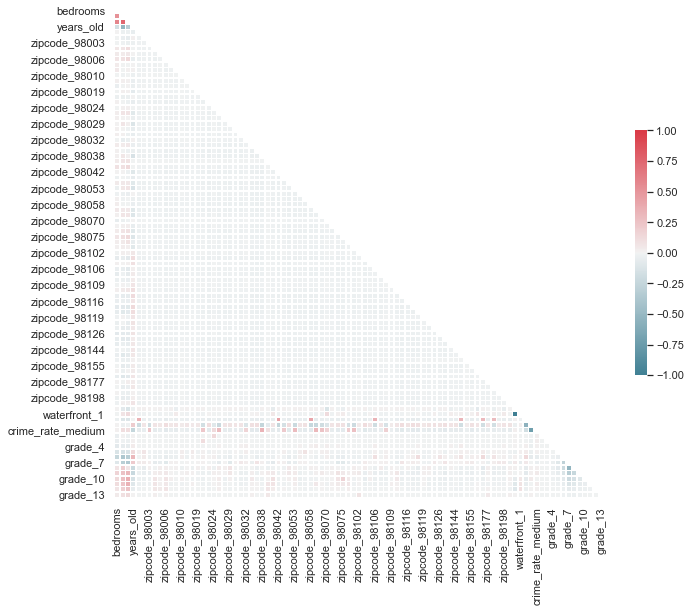

In [82]:
sns.set(style="white")


# Compute the correlation matrix
corr = X_train_8.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [83]:
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

#if you change inplace to True it will go through and drop all of those columns from the dataset
X_train_8.drop(columns=to_drop, inplace=False)
X_test_8.drop(columns=to_drop, inplace=False)

,bedrooms,bathrooms,sqft_living,years_old,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,waterfront_0,crime_rate_high,crime_rate_low,crime_rate_medium,grade_1,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
13347,4,2.75,1610,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
12171,3,2.00,1610,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5900,3,1.75,1900,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
7160,4,3.50,2690,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
13494,3,1.75,1170,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4742,4,2.25,1900,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
11094,4,2.50,1870,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5004,4,2.25,2320,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
5925,3,3.25,1530,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [84]:
to_drop

['waterfront_1']

## F Test

In [144]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

selector = SelectKBest(f_regression, k=150)

selector.fit(X_train_poly, y_train_poly)

SelectKBest(k=150, score_func=<function f_regression at 0x14657e4c0>)

In [145]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 4277 but corresponding boolean dimension is 4655

In [141]:
len(list(removed_columns))

4127

In [142]:
len(list(selected_columns))

150

In [143]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest.fit(X_train_poly[selected_columns], y_train_poly)

y_train_kbest = lm_kbest.predict(X_train_poly[selected_columns])


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train_poly, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test_poly[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test_poly, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 161569.19597975578
Testing Root Mean Squared Error: 162154.56472633424


In [129]:
list(zip(selected_columns, lm_kbest.coef_))

[('bedrooms', -40425.96224476374),
 ('bathrooms', 102116.4987384634),
 ('sqft_living', 117.27873261591847),
 ('zipcode_98004', 639230.6968292785),
 ('waterfront_0', 38915.190827674494),
 ('waterfront_1', -38915.1908395509),
 ('crime_rate_high', 84857.75457003126),
 ('crime_rate_low', 11418.737877084272),
 ('grade_7', 9739.844940512692),
 ('grade_9', -144082.85781751032),
 ('grade_10', -65262.844731386016),
 ('grade_11', 25190.336182336978),
 ('grade_12', -59992.50036902196),
 ('grade_13', 1265141.478234934),
 ('bedrooms^2', 1038.6314899299737),
 ('bedrooms bathrooms', 3489.931499222588),
 ('bedrooms sqft_living', -0.044992799952183304),
 ('bedrooms zipcode_98004', -47477.93557622422),
 ('bedrooms zipcode_98040', 15840.929145814081),
 ('bedrooms waterfront_1', 45611.72367229596),
 ('bedrooms crime_rate_low', 5636.781927899447),
 ('bedrooms grade_7', 3894.540978242645),
 ('bedrooms grade_9', 1568.2466922066808),
 ('bedrooms grade_10', -8849.595371294978),
 ('bedrooms grade_11', -137479.6

In [130]:
print('Log: ',log_test_rmse,'\n'
    'Poly_2: ', test_2rmse, '\n',
      "KBest:   ", testK_rmse,'\n')

Log:  136243.7076432464 
Poly_2:  137471.71616953306 
 Poly_3:  137471.71616953306 
 KBest:    167533.24609347145 



# Final Model

In [96]:
selector = SelectKBest(f_regression, k=150)

selector.fit(df_poly2, target)

SelectKBest(k=30, score_func=<function f_regression at 0x14657e4c0>)

In [98]:
lm_final = LinearRegression()
lm_final = lm_final.fit(X_train_poly[selected_columns], y_train_poly)

# #instantiate a linear regression object
# lm_final = LinearRegression()

# #fit the linear regression to the data
# lm_final = lm_final.fit(df_poly3[selected_columns], target)

In [103]:
lm_final.coef_

array([-3.85495998e+04,  9.45160562e+04,  1.19823678e+02,  6.11619567e+05,
        3.91250512e+04, -3.91250512e+04,  2.29277857e+04,  6.61960213e+03,
        3.00817529e+04, -1.16685726e+05, -4.98666809e+04,  5.91659431e+04,
       -2.14275552e+05,  1.24311844e+06,  5.83074079e+02,  5.80326059e+03,
       -2.85352801e+00, -3.10176608e+04,  2.08008050e+04,  5.50816893e+04,
        4.62700295e+03,  6.24546030e+03,  6.60234899e+03, -3.79381890e+03,
       -8.49747449e+04,  4.20407713e+04,  7.80854724e+04, -1.08579690e+04,
        5.86949688e+00, -4.46751347e+02, -2.68093751e+04, -6.75008592e+04,
        5.20785555e+04,  4.30495021e+04,  1.43773997e+03,  9.30783310e+04,
       -2.64847221e+03, -2.30621874e+04,  3.68749322e+03,  7.87985502e+04,
        8.73931886e+04, -8.38190564e+04,  1.35305397e+06, -6.48528487e-03,
        1.22577912e+00,  1.67464214e+02,  3.48789393e+02,  9.69125511e+00,
        7.82701077e+01, -2.59985772e+01,  1.45822342e+02,  2.65164669e+01,
       -5.55321723e+01,  

In [105]:
import pickle

pickle_out = open("model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()